In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.simplefilter(action="ignore")

from statsmodels.stats.weightstats import ttest_ind
from scipy import stats
from sklearn import metrics

%matplotlib inline

## Load Raw Dataset 
---

In [2]:
data = pd.read_stata("dataraw_thesis_redi.dta")
data.sample(5)

,index,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,...,pm24e,pm24f,pm24g,pm24h,educ,pt,ak,unemployment_rate,sample,parent_Working
1452,1452,0,3,21.0,single,105080008,3,1050800,8.0,1050800,...,1.0,0.0,0.0,0.0,4.0,473.0,2653.0,0.178289,4306.0,0
6309,6309,1,3,24.0,divorced,229230005,3,2292300,5.0,,...,0.0,0.0,0.0,1.0,NaN,23.0,831.0,0.027677,1259.0,1
680,680,1,3,18.0,single,277130004,3,2771300,4.0,2771300,...,0.0,0.0,1.0,0.0,3.0,178.0,1050.0,0.169524,1964.0,1
932,932,1,3,22.0,single,003260004,3,0032600,4.0,0032600,...,1.0,0.0,1.0,1.0,3.0,301.0,1454.0,0.207015,2627.0,1
5639,5639,0,3,23.0,single,088040004,3,0880400,4.0,,...,1.0,1.0,0.0,0.0,4.0,61.0,820.0,0.074390,1242.0,0


In [3]:
data.shape

(9348, 92)

### Adjusting nominal

In [4]:
data["asset_t"] = data[["A_hr1type_t", "E_hr1type_t", "F_hr1type_t"]].sum(axis=1)
data["asset_t1"] = data[["A_hr1type_t1", "E_hr1type_t1", "F_hr1type_t1"]].sum(axis=1)

In [5]:
for i in ["pce_t1", "asset_t1"]:
    data[i] = data[i] / (data["IHK_t1"] /100)
for i in ["pce_t", "asset_t"]:
    data[i] = data[i] / (data["IHK"] / 100)

In [6]:
data["desil_pce_t"] = pd.qcut(data.pce_t, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
data["desil_asset_t"] = pd.qcut(data.asset_t, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

data["desil_pce_t1"] = pd.qcut(data.pce_t1, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
data["desil_asset_t1"] = pd.qcut(data.asset_t1, q=10, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

data["quart_pce_t"] =pd.qcut(data.pce_t, q=4, labels=["1", "2", "3", "4"])
data["quart_asset_t"] =pd.qcut(data.asset_t, q=4, labels=["1", "2", "3", "4"])

data["quart_pce_t1"] =pd.qcut(data.pce_t1, q=4, labels=["1", "2", "3", "4"])
data["quart_asset_t1"] =pd.qcut(data.asset_t1, q=4, labels=["1", "2", "3", "4"])

In [7]:
data["asset_t_percap"] = data.asset_t / data["hhsize"]
data["asset_t1_percap"] = data.asset_t1 / data["hhsize"]

In [8]:
def tk01(data):
    if data == 95:
        return 5
    elif data == 2:
        return 3
    elif data == 3:
        return 2
    else:
        return data

In [9]:
data.tk01 = data.tk01.apply(lambda x: tk01(x)) #the ordered

In [10]:
def age(data):
    if data <= 16:
        return 1
    elif data <= 18:
        return 2
    elif data <= 20:
        return 3
    elif data <= 22:
        return 4
    else:
        return 5

In [11]:
data["agegr"] = data["age"].apply(lambda x: age(x))

In [12]:
def hhsize(data):
    if data <= 4:
        return 0
    elif data <= 8:
        return 1
    else:
        return 2

In [13]:
data["hhsizegg"] = data["hhsize"].apply(lambda x: hhsize(x))

In [14]:
for i in data.columns:
    if 95 in (data[i].unique()):
        print (95, i, True)
    elif "95" in (data[i].unique()):
        print ("95", i, True)

95 index True
95 tk16h True
95 dl06 True
95 us06 True


In [15]:
data.tk16h = data.tk16h.apply(lambda x: np.nan if x in [95, 99] else x)

In [16]:
# for t-1
ihk = pd.read_csv("C:/Users/Redata/Downloads/cpi indonesia after modelling 2000 - 2016 (511 cities inflation).csv")
ihk = ihk[(ihk["year"] == 2014) & (ihk["jenis"] == "Umum")][["kabid14", "jawa"]]

data = pd.merge(data, ihk, left_on="kabid", right_on="kabid14", how="left").drop_duplicates()
data.shape

(9348, 108)

In [17]:
#convert value 8 and 9 which mean dont know to missing
data["sw01"] = data["sw01"].apply(lambda x: np.nan if x in [8, 9] else x)
data["sw03b"] = data["sw03b"].apply(lambda x: np.nan if x in [8, 9] else x)

#convert value 7 which mean refuse answer relogious rate to missing
data["tr11"] = data["tr11"].apply(lambda x: np.nan if x == 7 else x)

## Handle Missing Values
---
At first to understand, it doesn’t exist a good way to deal with missing data. Different solutions exist for data imputation which however depends on the kind of problem. Many data are missing because several reason such as the response was out of range, questionable, or not applicable; or respondent refused to answer or didn’t know. So, missing data have several types. First step, we should distinguish between missing at random and not random because of maybe interviewer error. Several methode that can be used for single Imputation, like listwise deletion, central tendency (mean/median/mode), Hot-Cold Deck, nor Regression. ***However, values found in single imputation might be biased by the specific values in the current data set, and not represent the total values of the full population***. This problem can be reduuce with multiple imputation. It metode has a lot of advantages over traditional single imputation methods. Multiple Imputation is an imputation method that works with the assumption that the missing data are missing at Random. The algorithm works by running multiple models and each missing value is modeled conditionally depending on the observed values.

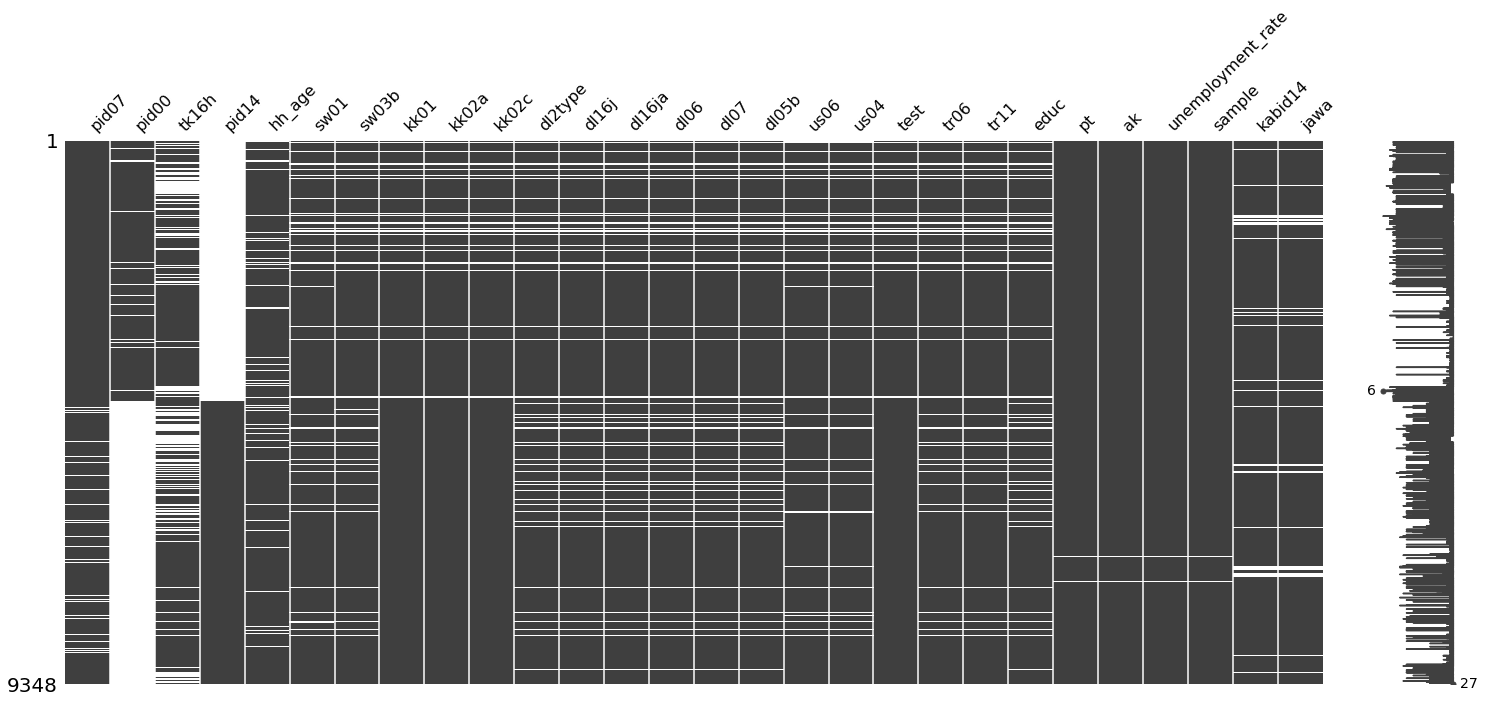

In [18]:
missingdata = data.columns[data.isnull().any()].tolist()
msno.matrix(data[missingdata]);

In [19]:
for i in data.columns:
    if data[i].isnull().sum() > 0:
        print (f"Percenage of missing data in {i} equal to", data[i].isnull().sum()/len(data))

Percenage of missing data in pid07 equal to 0.038510911424903725
Percenage of missing data in pid00 equal to 0.5483525887890458
Percenage of missing data in tk16h equal to 0.22657252888318358
Percenage of missing data in pid14 equal to 0.4797817715019255
Percenage of missing data in hh_age equal to 0.06974753958065896
Percenage of missing data in sw01 equal to 0.055947796320068466
Percenage of missing data in sw03b equal to 0.0561617458279846
Percenage of missing data in kk01 equal to 0.02973898160034232
Percenage of missing data in kk02a equal to 0.030915703893881045
Percenage of missing data in kk02c equal to 0.02973898160034232
Percenage of missing data in dl2type equal to 0.07113821138211382
Percenage of missing data in dl16j equal to 0.07220795892169447
Percenage of missing data in dl16ja equal to 0.07167308515190415
Percenage of missing data in dl06 equal to 0.07113821138211382
Percenage of missing data in dl07 equal to 0.07113821138211382
Percenage of missing data in dl05b equal

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [21]:
#create new a random forest model
random_forest = RandomForestClassifier(random_state=101 , 
                                      min_samples_split=25, min_samples_leaf=5,
                                      bootstrap=True, n_estimators=500)

param_grid = { 
    'bootstrap': [True],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [20, 25, 30, 35],
    'n_estimators': [300, 400, 500, 600]
}

#use gridsearch to test all values for n_neighbors
#randomf_gscv = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 6)

In [22]:
train_data = data.copy()

In [23]:
train_data.sw01.value_counts(dropna=False)

3.0    4517
4.0    2305
2.0    1403
NaN     523
1.0     383
5.0     188
6.0      29
Name: sw01, dtype: int64

## Categorical

In [24]:
%%time

#fit model to data
col_to_impute = ["sw01", "sw03b", "kk01", "kk02c", "educ", "dl07", "dl05b", 
                 "tk16h", "dl16j", "kk02a", "tr06", "tr11", "jawa"]
for i in col_to_impute:
    df = train_data[train_data[i].notnull()]
    df1 = train_data[train_data[i].isnull()]
    list_independent = ["pce_t", "A_hr1type_t", "E_hr1type_t", "F_hr1type_t",  "age", "sex", "kabid", "married", "year"]
    X = df[list_independent] #independent variable to predict
    y = df[i]
    random_forest.fit(X, y)
    #predict
    X_test = df1[list_independent]
    df1[i] = random_forest.predict(X_test)
    train_data = pd.concat([df, df1])
    #X_r = dataset[list_independent]
    #y_r = dataset[i]
    random_forest.fit(X, y)
    y_arbit = random_forest.predict(X)
    print ("Score of model in ", i, "is", metrics.accuracy_score(y, y_arbit))

Score of model in  sw01 is 0.6662889518413597
Score of model in  sw03b is 0.7057690128074351
Score of model in  kk01 is 0.6952590959206174
Score of model in  kk02c is 0.6930540242557883
Score of model in  educ is 0.7354600944374065
Score of model in  dl07 is 0.6872048831049177
Score of model in  dl05b is 0.8446389496717724
Score of model in  tk16h is 0.7881051175656985
Score of model in  dl16j is 0.5566701256773896
Score of model in  kk02a is 0.6437796666298709
Score of model in  tr06 is 0.7810450124406243
Score of model in  tr11 is 0.7187641466727026
Score of model in  jawa is 1.0
Wall time: 7min 31s


## Continuous

In [25]:
random_forest_1 = RandomForestRegressor(random_state=100 , 
                                      min_samples_split=10, min_samples_leaf=2,
                                      bootstrap=True, n_estimators=500)

col_to_impute = ["test", "us06", "us04", "unemployment_rate", "pt", "ak", "sample", "hh_age"]
for i in col_to_impute:
    df = train_data[train_data[i].notnull()]
    df1 = train_data[train_data[i].isnull()]
    list_independent = ["pce_t", "A_hr1type_t", "E_hr1type_t", "F_hr1type_t", "age", "sex", "kabid", "married", "year"]
    X = df[list_independent] #independent variable to predict
    y = df[i]
    random_forest_1.fit(X, y)
    #predict
    X_test = df1[list_independent]
    df1[i] = np.round(random_forest_1.predict(X_test))
    train_data = pd.concat([df, df1])
    print ("Score of model in ", i, "is", random_forest_1.score(X, y))

Score of model in  test is 0.6495211488380085
Score of model in  us06 is 0.6464978945560546
Score of model in  us04 is 0.6702892994103753
Score of model in  unemployment_rate is 0.9967381166619573
Score of model in  pt is 0.9987592809914129
Score of model in  ak is 0.9982530151216054
Score of model in  sample is 0.9987054973739591
Score of model in  hh_age is 0.6486917716291735


In [26]:
for i in train_data.columns:
    if train_data[i].isnull().sum() > 0:
        print (f"Percenage of missing data in {i} equal to", train_data[i].isnull().sum()/len(train_data))

Percenage of missing data in pid07 equal to 0.038510911424903725
Percenage of missing data in pid00 equal to 0.5483525887890458
Percenage of missing data in pid14 equal to 0.4797817715019255
Percenage of missing data in dl2type equal to 0.07113821138211382
Percenage of missing data in dl16ja equal to 0.07167308515190415
Percenage of missing data in dl06 equal to 0.07113821138211382
Percenage of missing data in kabid14 equal to 0.06311510483525888


|variable|description|
|---|---|
|tk01| main acivity|
|---|---|
|dl02 | Can read an bahasa|
|dl03| Can write an bahasa  |
|dl06| highest education attainment|
|dl05a| first age entered elementary school|
|dl11d| gratuated?|
|dl11f| year of graduated OR dropout|
|---|---|
|si21a | IDR 1,000,000 today or IDR 1,000,000 in 1 year|
|si21b | IDR 1,000,000 today or IDR 3,000,000 in 1 year|
|si22b | IDR 1,000,000 today or IDR 4,000,000 in 5 years|
|---|---|
|sw00| overall subjective welfare right now|
|sw01| subjective economic status|
|sw03b| subjective household condition|
|---|---|
|tr06 | How safe do you consider this village?|
|tr11 | How religious are you?|
|---|---|
|km01a | Have you ever had (tobacco habit)?|
|kk01| subjective overall health condition|
|kk02a| days missed at primary activity last month|
|kk02c| Compared health 12 months ago|
|---|---|
|ar02b| relation with Head Household|
|sc21x| migration history|
|pm24 | Did you vote in the most recent election|

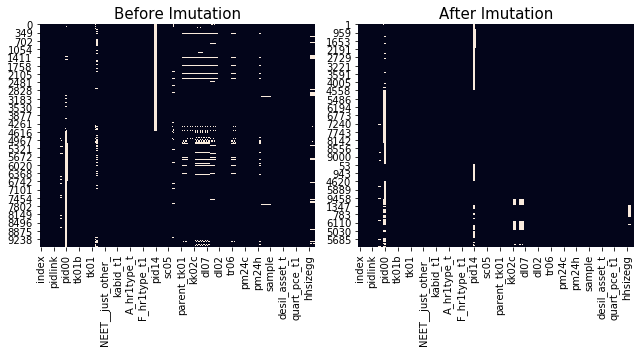

In [27]:
plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
sns.heatmap(data.isnull(), cbar=False)
plt.title("Before Imutation", size=15)
plt.subplot(1,2,2)
sns.heatmap(train_data.isnull(), cbar=False)
plt.title("After Imutation", size=15)
plt.tight_layout()

## Transform
---

### Made year of schooling

In [28]:
# make year of schooling based on indonesian education system
def year_of_schooling(data):
    if data == 1:
        return 6
    elif data == 2:
        return 9
    elif data == 3:
        return 12
    elif data == 4:
        return 16
    else:
        return np.nan

train_data["educ"] = train_data["educ"].apply(lambda x: year_of_schooling(x))

In [29]:
a = train_data[train_data["dl07"] == 7]
b = train_data[train_data["dl07"] != 7]

In [30]:
#limitation >> dropout in highest grade equal to graduated
# and droput in lowest grade equal to never attain the education

def sdd(data):
    if data == 0:
        return 6
    elif data == 1:
        return 5
    elif data == 2:
        return 4
    elif data == 3:
        return 3
    elif data == 4:
        return 2
    elif data == 5:
        return 1
    else: 
        return 0
    
sd = b[b["educ"] == 6]
sd["grade"] = sd["dl07"].apply(lambda x: sdd(x))
sd["educ"] = sd["educ"] - sd["grade"]

In [31]:
def high_school(data):
    if data == 0:
        return 3
    elif data == 1:
        return 2
    elif data == 2:
        return 1
    else: 
        return 0
    
smp = b[b["educ"] == 9]
smp["grade"] = (smp["dl07"].apply(lambda x: high_school(x)))
smp["educ"] = smp["educ"] - smp["grade"]

sma = b[b["educ"] == 12]
sma["grade"] = (sma["dl07"].apply(lambda x: high_school(x)))
sma["educ"] = sma["educ"] - sma["grade"]

In [32]:
def college(data):
    if data == 0:
        return 4
    elif data == 1:
        return 3
    elif data == 2:
        return 2
    elif data == 3:
        return 1
    else: 
        return 0
    
kuliah = b[b["educ"] == 16]
kuliah["grade"] = kuliah["dl07"].apply(lambda x: college(x))
kuliah["educ"] = kuliah["educ"] - kuliah["grade"]

In [33]:
df = pd.concat([a, sd, smp, sma, kuliah])
df.sample(10)

,index,sex,respondent,age,marstat,pidlink,ar02b,hhid07,pid07,hhid00,...,quart_asset_t,quart_pce_t1,quart_asset_t1,asset_t_percap,asset_t1_percap,agegr,hhsizegg,kabid14,jawa,grade
1938,1915,0,3,20.0,single,201020003,3,2010200,3.0,2010200,...,2,1,1,2.398492e+07,6.868410e+06,3,0,3402.0,1.0,6.0
8790,8600,0,3,17.0,single,275150004,3,2751500,4.0,,...,1,2,2,5.641297e+06,6.735220e+06,2,1,5108.0,0.0,1.0
6112,5991,0,3,18.0,single,162153105,3,1621531,5.0,,...,2,1,4,6.635043e+06,1.161152e+07,2,1,3303.0,1.0,NaN
9564,9338,0,3,24.0,married,311180011,10,3111800,NaN,,...,4,4,4,7.670096e+07,1.695718e+07,5,1,7310.0,0.0,1.0
637,629,1,3,16.0,single,209160006,3,2091600,6.0,2091600,...,3,1,1,2.623733e+07,4.222556e+06,1,0,3403.0,1.0,2.0
6369,6247,1,3,24.0,single,207090005,3,2070900,5.0,,...,4,4,3,2.709332e+07,1.157467e+07,5,1,3403.0,1.0,NaN
5520,5403,1,3,15.0,single,036203103,3,0362031,3.0,,...,3,4,4,1.825861e+07,1.322751e+07,1,1,1374.0,0.0,2.0
2100,2077,0,3,24.0,single,239020004,3,2390200,4.0,2390200,...,4,2,2,3.513847e+07,8.799228e+06,5,0,3516.0,1.0,NaN
3929,3868,1,3,18.0,single,273130004,3,2731300,4.0,2731300,...,4,3,4,2.570694e+07,1.388264e+07,2,1,5108.0,0.0,1.0
6538,6416,1,3,22.0,single,252150003,3,2521500,3.0,,...,4,3,3,4.576509e+07,1.160210e+07,4,0,3528.0,1.0,NaN


### Storing dataset

In [34]:
#Make body mass index variable
df["bmi"] = df["us06"] / ((df["us04"]/100)**2)

#Labor force participation rate
df["lfpr"] = df["ak"] / df["sample"]

In [35]:
df.to_stata("data_thesis_redi.dta")

In [36]:
df.shape

(9348, 111)